In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.signal import convolve2d
from scipy.signal.windows import gaussian
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import gaussian_filter
from skimage.util import img_as_float
from skimage.feature import peak_local_max

## 1. Scale-space blob detector

### Problem 1.1

In [2]:
def create_blob(sigma, set_N=False, N_selected=None):
    """Function for generating a gaussian blob for a given sigma"""
    if set_N == False:
        N = int(10*sigma)  # the axis scales are set to 10 times sigma
    else:
        N = N_selected
    blob_1d = gaussian(N, sigma)  # create the 1D discrete gaussian
    blob_2d = np.outer(blob_1d, blob_1d)  # expand to 2D
    blob_2d /= np.sum(blob_2d)  # normalize gaussian (integral should be 1)
    return blob_2d

def compute_scale_space(blob, tau):
    """Function for computing the scale space of the blob image"""
    G = create_blob(tau)  # create gaussian to compute scale space
    scale_space = convolve2d(blob, G)
    return scale_space

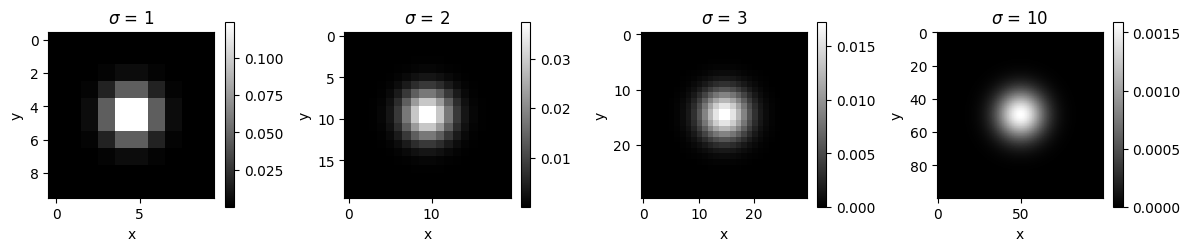

In [3]:
test_sigma = np.array([1, 2, 3, 10])
test_blob = []

for sigma in test_sigma:
    test_blob.append(create_blob(sigma))


plt.figure(figsize=(12, 4))
for i in range(len(test_blob)):
    plt.subplot(1, 4, i+1)
    plt.imshow(test_blob[i], cmap="gray")
    plt.title(rf"$\sigma$ = {test_sigma[i]}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(shrink=0.5)

plt.tight_layout()

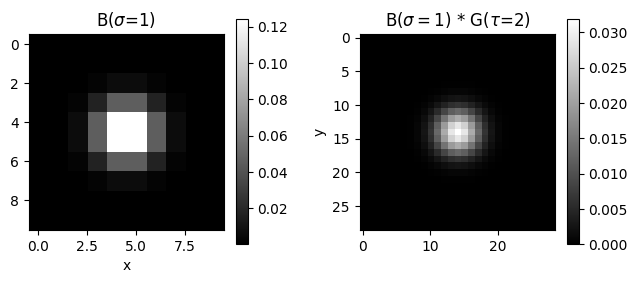

In [4]:
sigma1 = 1
tau1 = 2

blob1 = create_blob(sigma=sigma1)
scale_space1 = compute_scale_space(blob1, tau=tau1)

plt.subplot(1, 2, 1)
plt.imshow(blob1, cmap="grey")
plt.colorbar(shrink=0.5)
plt.title(rf"B($\sigma$={sigma1})")
plt.xlabel("x")

plt.subplot(1, 2, 2)
plt.imshow(scale_space1, cmap="grey")
plt.colorbar(shrink=0.5)
plt.title(rf"B($\sigma={sigma1}$) * G($\tau$={tau1})")
plt.ylabel("y")

plt.tight_layout()

Text(0.5, 1.0, 'B($\\sigma$=sqrt(5))')

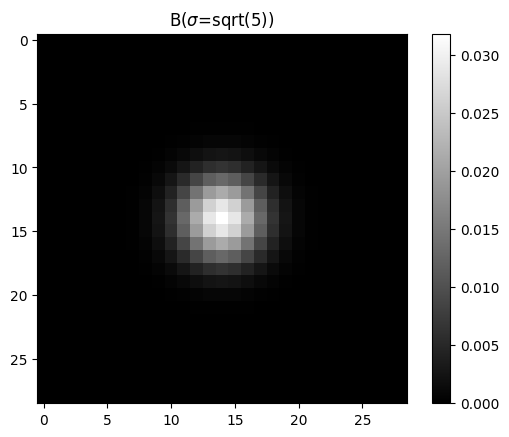

In [5]:
sigma_new = np.sqrt(sigma1**2 + tau1**2)

blob3 = create_blob(sigma=sigma_new, set_N=True, N_selected=len(scale_space1))

plt.imshow(blob3, cmap="grey")
plt.colorbar()
plt.title(rf"B($\sigma$=sqrt(5))")

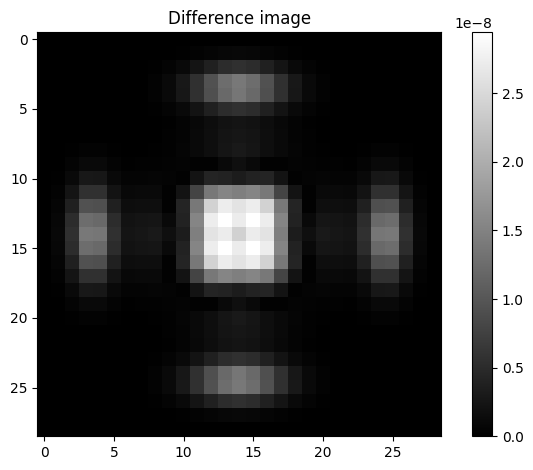

In [6]:
plt.imshow(np.abs(blob3-scale_space1), cmap="gray")
plt.colorbar()
plt.title("Difference image")
plt.tight_layout()

### Problem 1.2 iii)

In [7]:
def H(tau, sigma=1):
    return - tau**2 / (np.pi * (sigma**2 + tau**2)**2)

Text(0.5, 1.0, 'Scale normalized Laplacian at x=0, y=0')

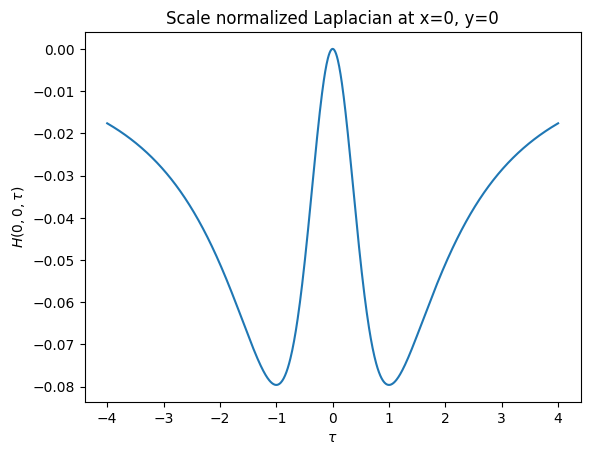

In [8]:
tau_axis = np.linspace(-4, 4, 1000)

plt.plot(tau_axis, H(tau_axis))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$H(0,0,\tau)$")
plt.title("Scale normalized Laplacian at x=0, y=0")

### Problem 1.3

Text(0.5, 1.0, 'Original image')

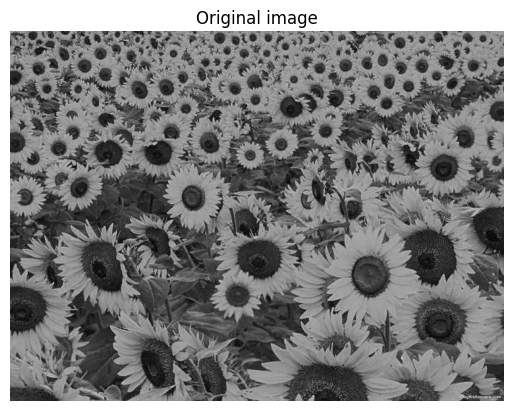

In [9]:
sunflower = img_as_float(imread("sunflower.tiff"))

plt.imshow(sunflower, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.title("Original image")

In [10]:
def scale_norm_laplacian(tau):
    """Calculate scale space of scale normalized Laplacian of sunflower.tiff"""
    return (tau**2 * gaussian_filter(sunflower, sigma=tau, order=(0, 2))
            + tau**2 * gaussian_filter(sunflower, sigma=tau, order=(2, 0)))


In [11]:
tau_values = np.linspace(3, 30, 100)
scale_norm_l_array = np.zeros((sunflower.shape[0], sunflower.shape[1], len(tau_values)))

for i, tau in enumerate(tau_values):    
    scale_norm_l_array[:, :, i] = scale_norm_laplacian(tau)

footprint = np.ones((3,3,3))
abs_peaks = peak_local_max(np.abs(scale_norm_l_array), num_peaks=150, footprint=footprint)

(-0.5, 749.5, 561.5, -0.5)

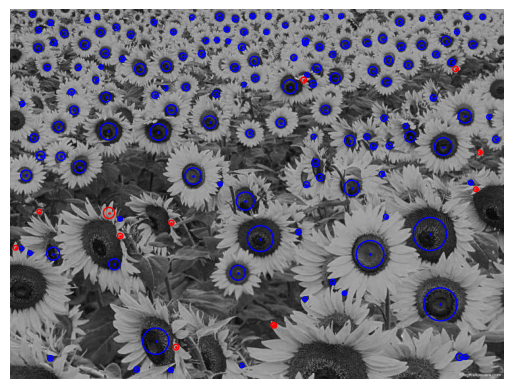

In [12]:
plt.imshow(sunflower, vmin=0, vmax=1, cmap="gray")

for i in range(len(abs_peaks[:,2])):
    if scale_norm_l_array[abs_peaks[i,0], abs_peaks[i,1], abs_peaks[i,2]] < 0:
        plt.scatter(abs_peaks[i,1], abs_peaks[i,0], s=1, c="red")
        circle = plt.Circle((abs_peaks[i,1], abs_peaks[i,0]), tau_values[abs_peaks[i,2]],
                            fill=False, color="red")
        plt.gca().add_patch(circle)
    elif scale_norm_l_array[abs_peaks[i,0], abs_peaks[i,1], abs_peaks[i,2]] > 0:
        plt.scatter(abs_peaks[i,1], abs_peaks[i,0], s=1, c="blue")
        circle = plt.Circle((abs_peaks[i,1], abs_peaks[i,0]), tau_values[abs_peaks[i,2]],
                            fill=False, color="blue")
        plt.gca().add_patch(circle)

plt.axis("off")

## 3. Fourier Transform - In Practice

### Problem 3.1

In [13]:
A = imread("trui.png")
A_powerspec = np.abs(fft2(A))**2
A_powerspec_shifted = fftshift(A_powerspec)

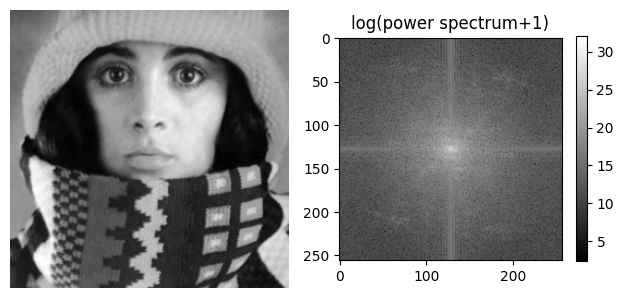

In [14]:
plt.subplot(1,2,1)
plt.imshow(A, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(np.log(A_powerspec_shifted+1), cmap="gray")
plt.title("log(power spectrum+1)")
plt.colorbar(shrink=0.5)

plt.tight_layout()

### Problem 3.2

In [15]:
def cos_func(x, y, a0, v0, w0):
    return a0 * np.cos(v0*x + w0*y)

def add_cos(image, a0, v0, w0):
    """Adds cosine waves to an image"""
    I = img_as_float(image)
    rows, cols = I.shape
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)
    I += cos_func(X, Y, a0=a0, v0=v0, w0=w0)
    return I

Text(0.5, 1.0, 'Cosine noise added')

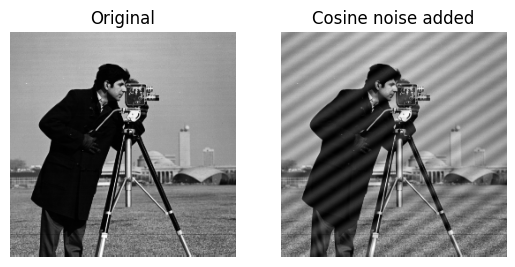

In [16]:
B = imread("cameraman.tif")

B_withcos = add_cos(B, 0.1, 0.2, 0.3)

plt.subplot(1,2,1)
plt.imshow(B, cmap="gray")
plt.axis("off")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(B_withcos, cmap="gray")
plt.axis("off")
plt.title("Cosine noise added")

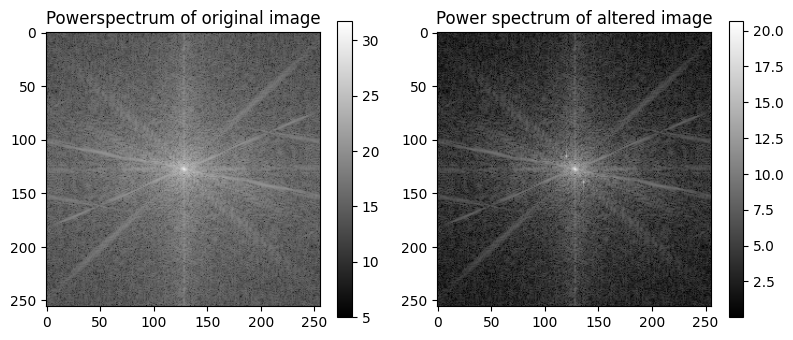

In [17]:
B_powerspec = np.abs(fft2(B))**2
B_withcos_powerspec = np.abs(fft2(B_withcos))**2

B_withcos_powerspec_shifted = fftshift(B_withcos_powerspec)
B_powerpec_shifted = fftshift(B_powerspec)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(np.log(B_powerpec_shifted+1), cmap="gray")
plt.title("Powerspectrum of original image")
plt.colorbar(shrink=0.8)

plt.subplot(1,2,2)
plt.imshow(np.log(B_withcos_powerspec_shifted+1), cmap="gray")
plt.title("Power spectrum of altered image")
plt.colorbar(shrink=0.8)

plt.tight_layout()

In [18]:
def cos_filter(image, v0, w0):
    """Filter for removing cosine noise from an image"""
    peak_row = int(np.round(w0/(2*np.pi)*image.shape[0]))
    peak_col = int(np.round(v0/(2*np.pi)*image.shape[1]))

    filter_f = np.ones(image.shape)
    filter_f[peak_row-1:peak_row+2, peak_col-1:peak_col+2] = 0
    filter_f[-peak_row-1:-peak_row+2, -peak_col-1:-peak_col+2] = 0

    image_filtered_ft = filter_f * fft2(image)
    image_filtered = np.real(ifft2(image_filtered_ft))

    return image_filtered

B_cos_filtered = cos_filter(B_withcos, v0=0.2, w0=0.3)

Text(0.5, 1.0, 'Cosine noise filtered away')

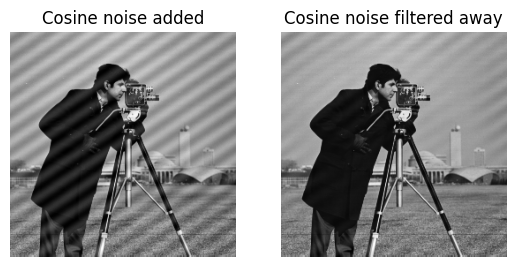

In [19]:
plt.subplot(1,2,1)
plt.imshow(B_withcos, cmap="gray")
plt.axis("off")
plt.title("Cosine noise added")

plt.subplot(1,2,2)
plt.imshow(B_cos_filtered, cmap="gray")
plt.axis("off")
plt.title("Cosine noise filtered away")